# Solve NP Problems

## Setup

In [ ]:
%pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.1/29.1 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.2/376.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.9/503.9 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 11.8 MB/s eta 0:00:00


In [ ]:
from NP_problems import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Colab/LLM/LLM_NP_Problems/BaseResults'

Mounted at /content/drive/


In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

gemini_api_key = os.getenv("GEMINI_API_KEY3")

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

MODEL_NAME = "gemini-2.5-flash"

chat_model = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0.01, api_key=gemini_api_key)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

## 3 SAT Problem

### Baseline

In [ ]:
import re
import time
from langchain_core.messages import SystemMessage, HumanMessage

def format_sat_problem_for_llm(clauses):
    sat_problem_parts = []
    for clause in clauses:
        temp_clause = [f"{'~' if var < 0 else ''}x{abs(var)}" for var in clause]
        str_clause = "(" + " v ".join(temp_clause) + ")"
        sat_problem_parts.append(str_clause)
    return " ∧ ".join(sat_problem_parts)

def create_sat_prompt(formatted_problem_str):
    system_content = (
        "You are an expert logic engine specializing in Boolean Satisfiability "
        "Problems (SAT). You will receive a 3-SAT problem instance, which consists "
        "of a conjunction of clauses, where each clause is a disjunction of three "
        "literals. Your task is to determine if a satisfying assignment of boolean "
        "values (True or False) exists for the variables that makes the entire "
        "formula True. If a solution exists, you must provide a valid satisfying "
        "assignment. If the formula is unsatisfiable, you must state that.\n\n"

        "CRITICAL REQUIREMENTS:\n"
        "- The solution must satisfy all clauses\n"
        "- Show your reasoning process step by step\n"
        "- Return only list all True variables in one line and all False variables in the other or the statement of unsatisfiablity.\n\n"

        "Example Output Format:\n"
        "True:\n"
        "[x1, x4, ...]"
        "False:\n"
        "[x2, x3, ...]"
    )

    human_content = (
        f"Please solve the following 3-SAT problem:\n\n{formatted_problem_str}\n\n"

        "Follow these steps to find a solution:\n"
        "1.  **Analyze the Clauses**\n"
        "    * Identify all unique variables in the clauses.\n"
        "2.  **Initial Solution**\n"
        "    * Start with an initial assignment for the variables. A good starting point is to set all variables to `True`.\n"
        "    * Check each clause to see if it is satisfied by your current assignment. A clause is satisfied if at least one of its literals is `True`.\n"
        "3.  **Iterate and Refine**:\n"
        "    * If all clauses are satisfied, you have found a solution. Present the final assignment.\n"
        "    * If not, you need to adjust your assignment. Identify the unsatisfied clauses and flip the value of variables in to satisfy them.\n"
        "    * Repeat until all clauses are satisfied.\n"
        "5.  **Conclusion**\n"
        "    * Provide the final assignment or state unsatisfiability in the required format without any additional texts.\n"
    )

    sys_msg = SystemMessage(content=system_content)
    human_msg = HumanMessage(content=human_content)

    return sys_msg, human_msg

def extract_assignment_from_output(llm_output):
    assignment = {}
    llm_output = llm_output.lower()

    try:
        conclusion_part = llm_output.split("conclusion")[-1]
        true_part = conclusion_part.split("true:")[1]
        false_part = conclusion_part.split("false:")[1]
    except IndexError:
        return {}

    pattern = re.compile(r"x(\d+)")

    for match in pattern.findall(true_part.strip()):
        var_index = int(match)
        assignment[var_index] = True

    for match in pattern.findall(false_part.strip()):
        var_index = int(match)
        assignment[var_index] = False

    return assignment

In [ ]:
def run_baseline(chat_model, system_message, human_message):
    messages = [system_message, human_message]
    start_time = time.time()
    answer = chat_model.invoke(messages).content
    end_time = time.time()
    execution_time = end_time - start_time
    return answer, execution_time

In [ ]:
def add_z3_result(results, args):
    if not isinstance(results, list):
        results = [results]
    for result in results:
        z3_solution, solve_time = args.z3_solver(*result['Generated'][:-1], result['Generator Parameters'])
        result['Z3 Solution'] = z3_solution
        result['Z3 Solve Time'] = solve_time

In [ ]:
def print_one_result(result):
    print("-" * 75)
    for key, val in result.items():
      print(f"{key}:\n{val}")
      print("-" * 75)

In [ ]:
class TestProblemArgs():
  def __init__(self, chat_model=None, generator=None, verifier=None, z3_solver=None, answer_extractor=None,problem_formatter=None, prompt_creator=None, generator_args=None):

    if chat_model is not None:
      self.chat_model = chat_model
    if generator is not None:
      self.generator = generator
    if verifier is not None:
      self.verifier = verifier
    if z3_solver is not None:
      self.z3_solver = z3_solver
    if answer_extractor is not None:
      self.answer_extractor = answer_extractor
    if problem_formatter is not None:
      self.problem_formatter = problem_formatter
    if prompt_creator is not None:
      self.prompt_creator = prompt_creator
    if generator_args is not None:
      self.generator_args = generator_args

In [ ]:
def test_one_problem(test_args: TestProblemArgs):
    result = {}
    result['Parameters'] = test_args
    result['Generator Parameters'] = test_args.generator_args

    generated = test_args.generator(**test_args.generator_args)
    result['Generated'] = generated

    problem_str = test_args.problem_formatter(*generated[:-1])
    result['Formatted Problem'] = problem_str

    system_message, human_message = test_args.prompt_creator(problem_str)
    result['System Message'] = system_message
    result['Human Message'] = human_message

    llm_response, llm_solve_time = run_baseline(test_args.chat_model, system_message, human_message)
    result['LLM Response'] = llm_response
    result['LLM Solve Time'] = llm_solve_time

    llm_answer = test_args.answer_extractor(llm_response)
    result['Extracted Answer'] = llm_answer

    is_correct, message = test_args.verifier(llm_answer, *generated)
    result['Is Correct'] = is_correct
    result['Message'] = message

    return result

In [ ]:
def run_baseline_batched(chat_model, system_messages, human_messages):
    message_batches = []
    for system, human in zip(system_messages, human_messages):
        message_batches.append([system, human])

    start_time = time.time()
    responses = chat_model.batch(message_batches)
    end_time = time.time()

    execution_time = (end_time - start_time) / len(system_messages)

    answers = [resp.content for resp in responses]
    times = [execution_time] * len(answers)

    return answers, times

In [ ]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint, uniform

def test_many_problems(args, n_problems, random_state=42):
    results = []
    generator_args_list = list(ParameterSampler(
        param_distributions = args.generator_args,
        n_iter=n_problems,
        random_state=random_state
    ))

    system_messages = []
    human_messages = []

    for generator_args in generator_args_list:
      args.generator_args = generator_args
      result = {}
      result['Parameters'] = args
      result['Generator Parameters'] = generator_args

      generated = args.generator(**generator_args)
      result['Generated'] = generated

      problem_str = args.problem_formatter(*generated[:-1])
      result['Formatted Problem'] = problem_str

      system_message, human_message = args.prompt_creator(problem_str)
      result['System Message'] = system_message
      result['Human Message'] = human_message

      system_messages.append(system_message)
      human_messages.append(human_message)
      results.append(result)

    llm_responses, llm_solve_times = run_baseline_batched(args.chat_model, system_messages, human_messages)
    for i, (llm_response, llm_time) in enumerate(zip(llm_responses, llm_solve_times)):
      result = results[i]
      result['LLM Response'] = llm_response
      result['LLM Solve Time'] = llm_time

      llm_answer = args.answer_extractor(llm_response)
      result['Extracted Answer'] = llm_answer

      is_correct, message = args.verifier(llm_answer, *result['Generated'])
      result['Is Correct'] = is_correct
      result['Message'] = message

    return results

In [ ]:
args = TestProblemArgs(chat_model, generate_3sat_instance,
                        lambda ans,c,_: verify_3sat_solution(ans,c),
                        lambda c,a: solve_3sat_with_z3(c, a['num_vars']),
                        extract_assignment_from_output, format_sat_problem_for_llm,
                        create_sat_prompt)

In [ ]:
args.generator_args = {'num_vars': 4, 'num_clauses': 6, 'use_random_weights': True}
result = test_one_problem(args)
print_one_result(result)

---------------------------------------------------------------------------
Parameters:
---------------------------------------------------------------------------
Generator Parameters:
{'num_vars': 4, 'num_clauses': 6, 'use_random_weights': True}
---------------------------------------------------------------------------
Generated:
([[-4, 3, 1], [1, 3, -2], [4, -2, -1], [-4, 3, -2], [3, -2, 4], [4, -2, -1]], {1: False, 2: False, 3: False, 4: False})
---------------------------------------------------------------------------
Formatted Problem:
(~x4 v x3 v x1) ∧ (x1 v x3 v ~x2) ∧ (x4 v ~x2 v ~x1) ∧ (~x4 v x3 v ~x2) ∧ (x3 v ~x2 v x4) ∧ (x4 v ~x2 v ~x1)
---------------------------------------------------------------------------
System Message:
content='You are an expert logic engine specializing in Boolean Satisfiability Problems (SAT). You will receive a 3-SAT problem instance, which consists of a conjunction of clauses, where each clause is a disjunction of three literals. Your task is 

In [ ]:
args.generator_args = {'num_vars': 10, 'num_clauses': 25, 'use_random_weights': True}
result = test_one_problem(args)
print_one_result(result)

---------------------------------------------------------------------------
Parameters:
---------------------------------------------------------------------------
Generator Parameters:
{'num_vars': 10, 'num_clauses': 25, 'use_random_weights': True}
---------------------------------------------------------------------------
Generated:
([[1, -7, -3], [1, -2, -7], [-9, 5, -3], [-3, -5, 9], [10, 9, 8], [10, -5, 8], [-10, -4, -9], [-4, 10, -1], [-9, -2, 7], [-7, -8, -5], [-8, -2, -6], [-1, 5, -3], [3, -7, -5], [2, -4, -9], [7, -2, 3], [-4, 7, 2], [8, -5, -4], [8, 3, 6], [-3, 6, 4], [8, 4, -2], [-3, 9, 5], [-8, 4, -10], [10, -9, 4], [-1, 7, -4], [-8, 7, 9]], {1: True, 2: False, 3: False, 4: False, 5: False, 6: True, 7: False, 8: False, 9: False, 10: True})
---------------------------------------------------------------------------
Formatted Problem:
(x1 v ~x7 v ~x3) ∧ (x1 v ~x2 v ~x7) ∧ (~x9 v x5 v ~x3) ∧ (~x3 v ~x5 v x9) ∧ (x10 v x9 v x8) ∧ (x10 v ~x5 v x8) ∧ (~x10 v ~x4 v ~x9) ∧ (~x4 v x1

In [ ]:
args.generator_args = {'num_vars': 100, 'num_clauses': 400, 'use_random_weights': True}
result = test_one_problem(args)
print_one_result(result)

---------------------------------------------------------------------------
Parameters:
---------------------------------------------------------------------------
Generator Parameters:
{'num_vars': 100, 'num_clauses': 400, 'use_random_weights': True}
---------------------------------------------------------------------------
Generated:
([[64, -4, -83], [21, -67, -49], [41, -45, -84], [80, 3, 11], [-46, 84, -97], [92, -7, 71], [48, 25, 46], [78, -81, -18], [74, 99, -43], [-80, 86, 72], [39, 27, 15], [65, 73, 87], [58, 29, 84], [-61, -14, 3], [-85, 17, -53], [89, 34, -18], [-38, 32, 15], [-40, -61, -80], [5, 8, 25], [-62, 64, 75], [-9, 29, 87], [2, -33, 78], [-70, 63, 10], [-21, 67, -60], [-58, 41, -54], [4, 7, -75], [-86, 62, -66], [-33, -54, 10], [94, 10, -88], [74, -86, -88], [-57, 69, 78], [-38, -30, 67], [-45, -78, -9], [-4, -33, -69], [-70, -88, -27], [-72, 57, 79], [-89, 74, -75], [51, 4, -79], [40, 84, -29], [25, -80, 62], [5, -93, -65], [89, -80, -60], [-52, -36, 55], [-52, -65

In [ ]:
n_problems = 100
args.generator_args = {'num_vars': randint(4,201), 'num_clauses': randint(4,201), 'use_random_weights': [True]}
results = test_many_problems(args, n_problems, random_state=42)

In [ ]:
add_z3_result(results, args)

In [ ]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def scatter_plot_correctness(X, y):
    """
    Scatterplot the correctness of the solution for every pair of parameters
    """
    for c1,c2 in itertools.combinations(X.columns, 2):
        x1 = X[c1]
        x2 = X[c2]
        z = ['green' if res else 'red' for res in y.values]

        plt.scatter(x1, x2, c=z)
        plt.xlabel(c1)
        plt.ylabel(c2)
        plt.title(f"Problem Success/Failure by {c1} and {c2}")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

def plot_correctness_distribution(X, y, n_bins=7):
    """
    Plot the proportion of correct solutions for each bin of each feature
    """
    for feature in X.columns:
        plt.figure(figsize=(6, 4))

        feature_values = X[feature]
        bins = np.linspace(feature_values.min(), feature_values.max(), n_bins+1)

        proportions = []
        bin_centers = []

        for i in range(len(bins) - 1):
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
            bin_center = (lower_bound + upper_bound) / 2

            in_bin_mask = (feature_values >= lower_bound) & (feature_values < upper_bound)

            if in_bin_mask.sum() > 0:
                correct_in_bin = y[in_bin_mask].sum()
                total_in_bin = in_bin_mask.sum()
                proportion = correct_in_bin / total_in_bin

                proportions.append(proportion)
                bin_centers.append(bin_center)

        plt.bar(bin_centers, proportions, width=(bins[1]-bins[0])*0.8)
        plt.xlabel(feature)
        plt.ylabel('Proportion Correct')
        plt.title(f'Proportion of Correct Solutions by {feature}')
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

def plot_feature_importance(X, y):
    """
    Train a classifier and plot the feature importance
    """
    feature_names = X.columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    importance = model.feature_importances_
    indices = np.argsort(importance)

    plt.figure(figsize=(6, len(feature_names)))
    plt.barh(range(len(indices)), importance[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")

def report_results(results):
    df = pd.DataFrame([res['Generator Parameters'] for res in results]).copy()
    df['Is Correct'] = [res['Is Correct'] for res in results]
    df['Prompt Token Count'] = [len(tokenizer(res['Human Message'].content)[0]) for res in results]

    features = list(key for key in results[0]['Generator Parameters'].keys()
        if type(results[0]['Generator Parameters'][key])!=bool)
    features.append('Prompt Token Count')

    X = df[features]
    y = df['Is Correct']

    scatter_plot_correctness(X, y)
    plot_correctness_distribution(X, y)

    plot_feature_importance(X.drop(columns=['Prompt Token Count']), y)

    print("LLM Solve Time (Average):", np.mean([res['LLM Solve Time'] for res in results]))
    print("LLM Solve Time (STD):", np.std([res['LLM Solve Time'] for res in results]))
    if 'Z3 Solve Time' in results[0].keys():
        print("Z3 Solve Time (Average):", np.mean([res.get('Z3 Solve Time',0) for res in results]))
        print("Z3 Solve Time (STD):", np.std([res.get('Z3 Solve Time',0) for res in results]))

In [ ]:
import pickle

def save_results(results,path):
    save_results = [dict() for res in results]

    for i, res in enumerate(results):
        for key in res.keys():
            if key == 'Parameters':
                continue
            save_results[i][key] = res[key]

    with open(path, 'wb') as f:
        pickle.dump(save_results, f)

def load_results(path):
    with open(path, 'rb') as f:
        results = pickle.load(f)
    return results

In [ ]:
save_results(results, os.path.join(path, 'SAT.pkl'))

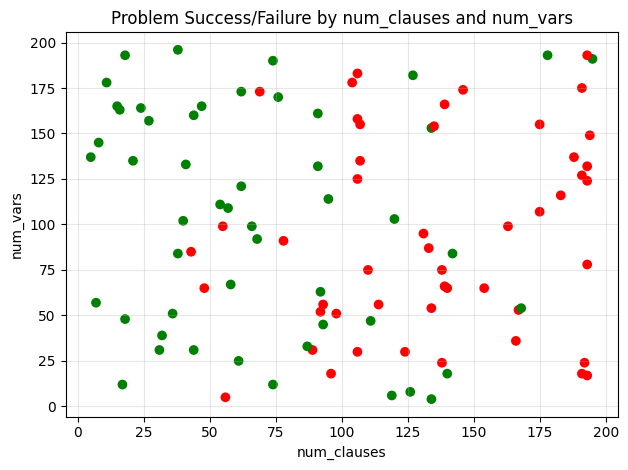

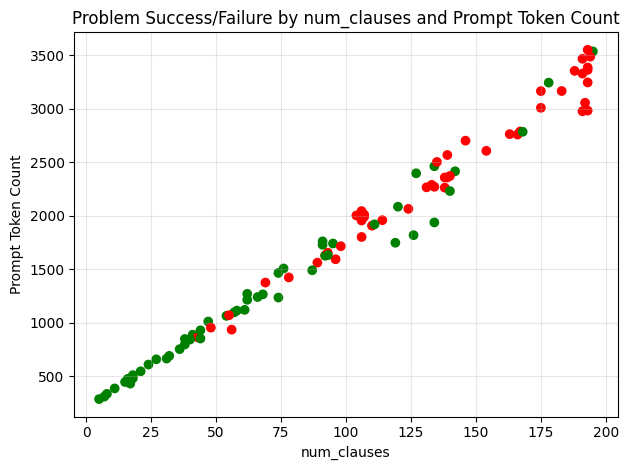

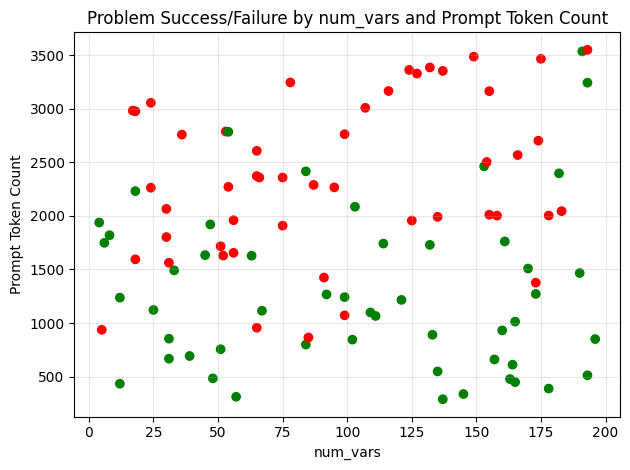

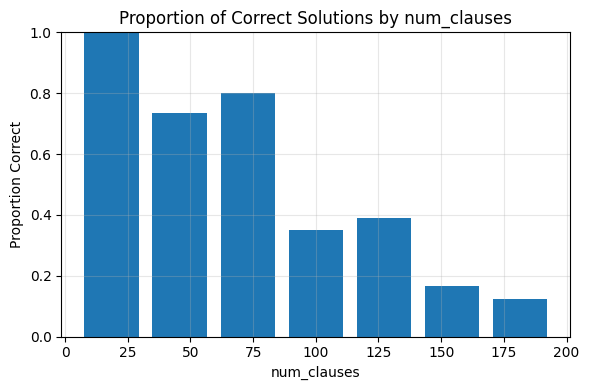

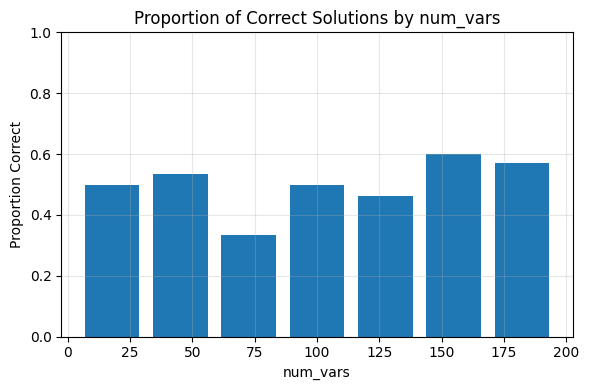

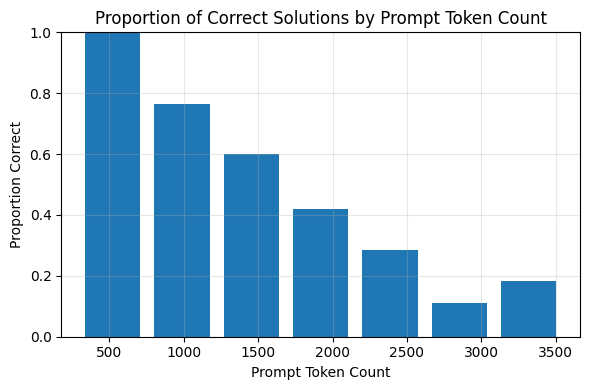

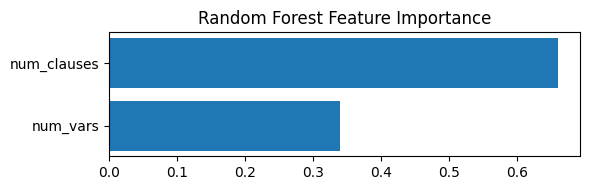

Accuracy: 0.8
F1 Score: 0.8
LLM Solve Time (Average): 18.09020211458207
LLM Solve Time (STD): 7.105427357601002e-15
Z3 Solve Time (Average): 0.024978232383728028
Z3 Solve Time (STD): 0.012181655376652703


In [ ]:
results = load_results(os.path.join(path, 'SAT.pkl'))
report_results(results)

## Subset Sum Problem

### Baseline

In [ ]:
import re
import time
from langchain_core.messages import SystemMessage, HumanMessage

def format_subset_sum_problem_for_llm(target, number_set):
    numbers_part = " ".join(str(number) for number in number_set)
    prompt = f"Numbers are\n{numbers_part}\nTarget is {target}"
    return prompt

def create_subset_sum_prompt(formatted_problem_str):
    system_content = (
        "You are an expert logic engine specializing in Subset Sum "
        "Problems (SSP). You will receive an SSP instance consisting of a list of "
        "positive numbers and a target sum. Your task is to determine if there exists "
        "a subset of these numbers whose sum equals the target. "
        "If a solution exists, you must provide the subset. If no solution exists, "
        "clearly state so.\n\n"

        "CRITICAL REQUIREMENTS:\n"
        "- The sum of all elements in the subset must be equal to the target\n"
        "- Show your reasoning process step by step\n"
        "- Return only list of selected numbers or state that no solution can be found.\n\n"

        "Example Output Format:\n"
        "[1, 4, ...]"
    )

    human_content = (
        f"Please solve the following SSP:\n\n{formatted_problem_str}\n\n"

        "Follow these steps to find a solution:\n"
        "1.  **Analyze the Input**\n"
        "    * List all numbers and the target sum.\n"
        "    * Start by identifying potential subsets.\n"
        "2.  **Initial Solution**\n"
        "    * Start with an initial subset of the numbers, such as the k smallest or largest numbers.\n"
        "    * Compute the sum of the selected subset and compare it to the target.\n"
        "3.  **Iterate and Refine Subset**\n"
        "    * If the sum equals the target, you have found a solution. output the subset as the solution.\n"
        "    * If not, you need to adjust the subset. Adjust the subset by adding or removing numbers based on the difference from the target.\n"
        "    * Repeat until a solution is found or all feasible subsets are exhausted.\n"
        "4.  **Conclusion**\n"
        "    * If a subset is found, provide the final subset in the required format without any additional texts. If no subset sums to the target, state 'No solution exists.'\n"
    )

    sys_msg = SystemMessage(content=system_content)
    human_msg = HumanMessage(content=human_content)

    return sys_msg, human_msg


def extract_subset_from_output(llm_output):
    try:
        conclusion_part = llm_output.split("[")[-1]
    except IndexError:
        return {}

    pattern = re.compile(r"\d+", re.IGNORECASE)
    subset = pattern.findall(conclusion_part.strip())
    return [int(number) for number in subset]

In [ ]:
args = TestProblemArgs(chat_model, generate_subset_sum_instance,
                      lambda ans,target,num,_: verify_subset_sum_solution(target,ans),
                      lambda t,s,_: solve_subset_sum_with_z3(t,s),
                      extract_subset_from_output, format_subset_sum_problem_for_llm,
                      create_subset_sum_prompt)

In [ ]:
args.generator_args = {'set_size': 30, 'subset_ratio': 0.3, 'min_val':10, 'range_val':90 }
result = test_one_problem(args)
print_one_result(result)

---------------------------------------------------------------------------
Parameters:
---------------------------------------------------------------------------
Generator Parameters:
{'set_size': 30, 'subset_ratio': 0.3, 'min_val': 10, 'range_val': 90}
---------------------------------------------------------------------------
Generated:
(550, [92, 82, 70, 67, 78, 49, 20, 75, 81, 20, 88, 48, 78, 20, 23, 39, 87, 30, 45, 82, 51, 63, 100, 77, 93, 12, 44, 89, 89, 42], [12, 20, 39, 42, 77, 82, 89, 89, 100])
---------------------------------------------------------------------------
Formatted Problem:
Numbers are
92 82 70 67 78 49 20 75 81 20 88 48 78 20 23 39 87 30 45 82 51 63 100 77 93 12 44 89 89 42
Target is 550
---------------------------------------------------------------------------
System Message:
content='You are an expert logic engine specializing in Subset Sum Problems (SSP). You will receive an SSP instance consisting of a list of positive numbers and a target sum. Your task 

In [ ]:
args.generator_args = {'set_size': 50, 'subset_ratio': 0.2, 'min_val':10, 'range_val':90}
result = test_one_problem(args)
print_one_result(result)

---------------------------------------------------------------------------
Parameters:
---------------------------------------------------------------------------
Generator Parameters:
{'set_size': 50, 'subset_ratio': 0.2, 'min_val': 10, 'range_val': 90}
---------------------------------------------------------------------------
Generated:
(527, [68, 22, 68, 80, 40, 69, 84, 38, 89, 34, 46, 29, 19, 12, 37, 28, 56, 64, 35, 46, 71, 12, 33, 45, 47, 31, 61, 51, 96, 93, 61, 68, 87, 71, 29, 60, 74, 87, 23, 97, 65, 50, 99, 50, 85, 84, 59, 56, 97, 55], [29, 31, 34, 46, 50, 51, 59, 60, 68, 99])
---------------------------------------------------------------------------
Formatted Problem:
Numbers are
68 22 68 80 40 69 84 38 89 34 46 29 19 12 37 28 56 64 35 46 71 12 33 45 47 31 61 51 96 93 61 68 87 71 29 60 74 87 23 97 65 50 99 50 85 84 59 56 97 55
Target is 527
---------------------------------------------------------------------------
System Message:
content='You are an expert logic engine spec

In [ ]:
args.generator_args = {'set_size': 200, 'subset_ratio': 0.9, 'min_val':1, 'range_val':200 }
result = test_one_problem(args)
print_one_result(result)

---------------------------------------------------------------------------
Generated:
(17651, [196, 112, 158, 67, 122, 88, 111, 120, 30, 147, 121, 161, 157, 172, 137, 2, 23, 190, 95, 188, 134, 58, 60, 14, 94, 157, 17, 198, 121, 68, 67, 3, 176, 66, 121, 147, 192, 35, 13, 68, 169, 36, 57, 133, 98, 121, 151, 129, 2, 187, 180, 69, 88, 75, 71, 100, 44, 179, 37, 1, 56, 74, 30, 13, 144, 52, 49, 79, 121, 189, 51, 15, 178, 197, 63, 49, 129, 127, 181, 128, 44, 182, 54, 128, 1, 119, 140, 113, 129, 43, 100, 194, 164, 109, 8, 163, 47, 123, 197, 17, 35, 61, 129, 189, 65, 88, 12, 77, 73, 159, 168, 179, 52, 49, 27, 182, 179, 104, 15, 100, 81, 36, 132, 73, 117, 86, 121, 156, 5, 170, 78, 159, 134, 120, 196, 29, 7, 61, 36, 38, 182, 180, 146, 63, 109, 179, 141, 31, 1, 77, 2, 181, 57, 161, 137, 4, 105, 133, 114, 79, 59, 52, 191, 30, 142, 69, 19, 23, 184, 88, 67, 37, 10, 114, 76, 118, 120, 108, 81, 83, 145, 82, 34, 136, 135, 65, 48, 174, 136, 8, 191, 52, 171, 58, 47, 2, 30, 129, 141, 19], [1, 1, 2, 2, 2, 2

In [ ]:
n_problems = 100
args.generator_args = {'set_size': randint(5,201), 'subset_ratio': uniform(0,1), 'min_val': randint(1,1001), 'range_val': randint(1,50001)}

results = test_many_problems(args, n_problems, random_state=42)
add_z3_result(results, args)
save_results(results, os.path.join(path, 'SSP.pkl'))

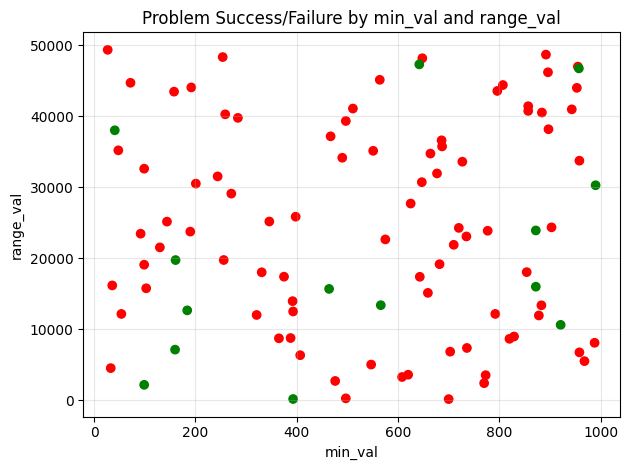

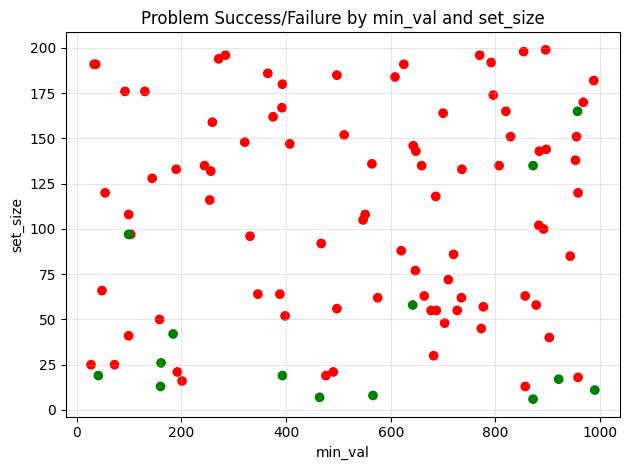

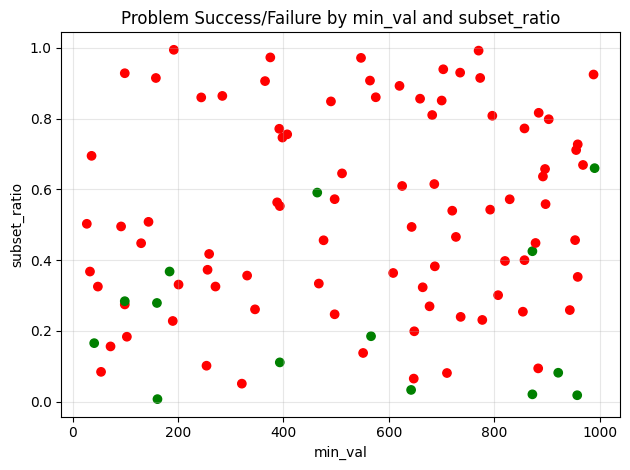

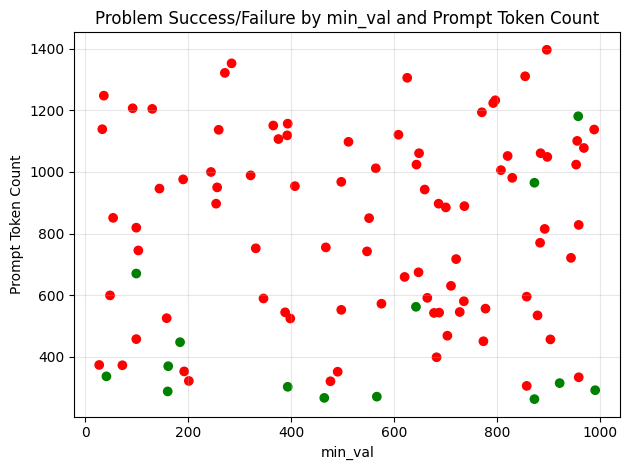

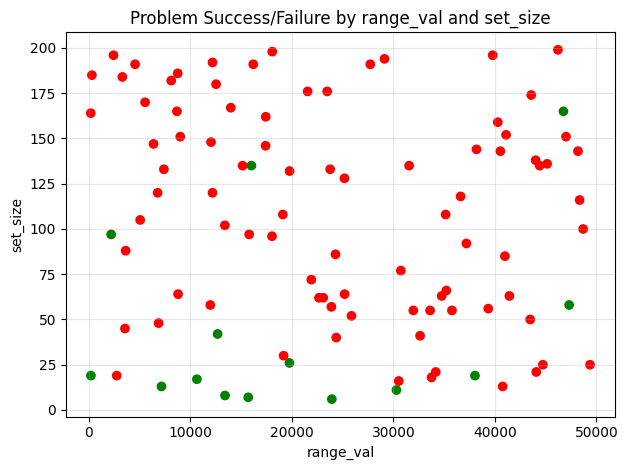

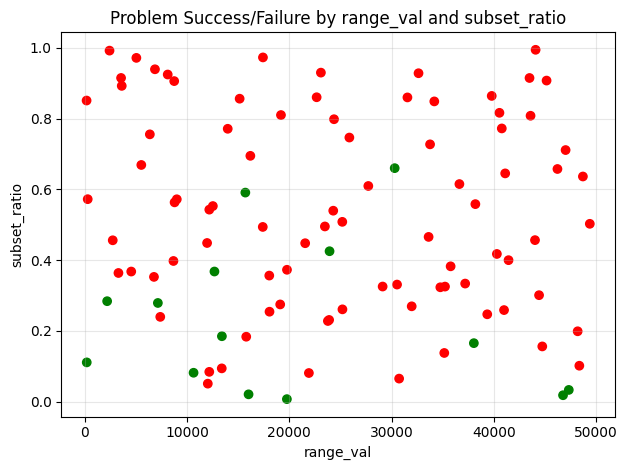

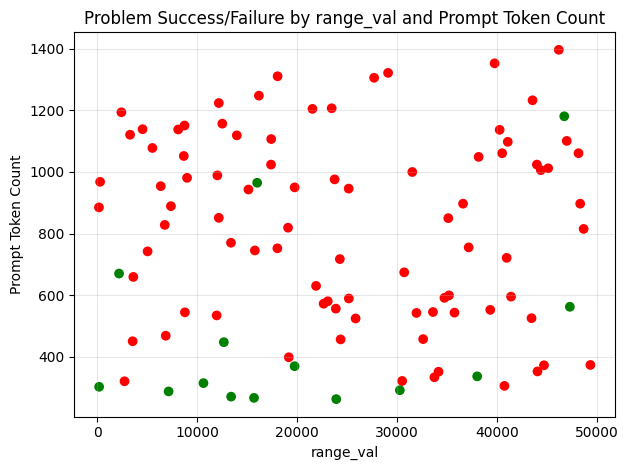

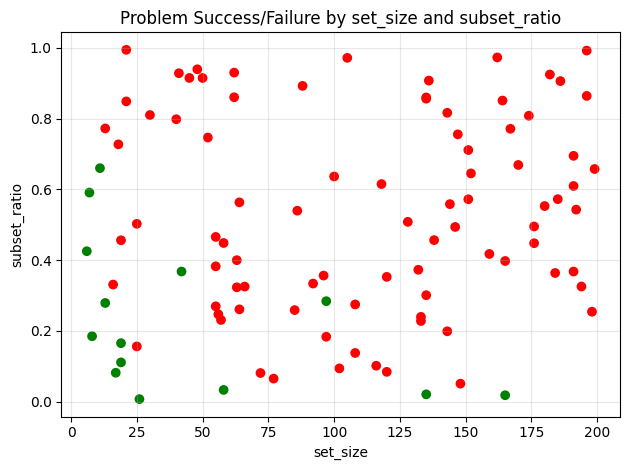

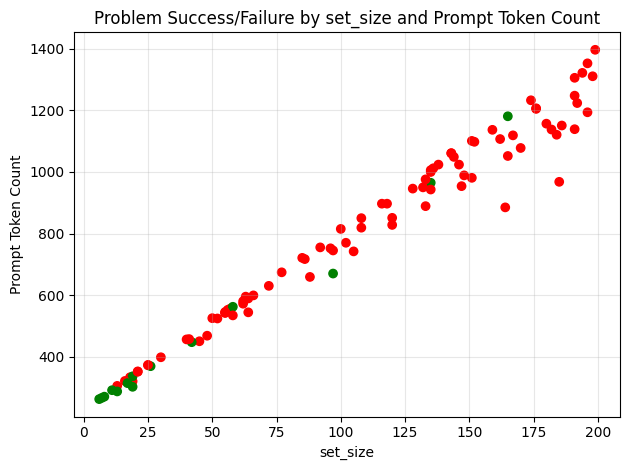

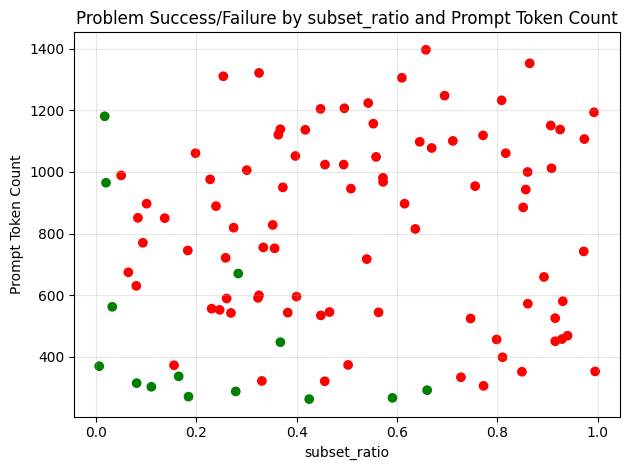

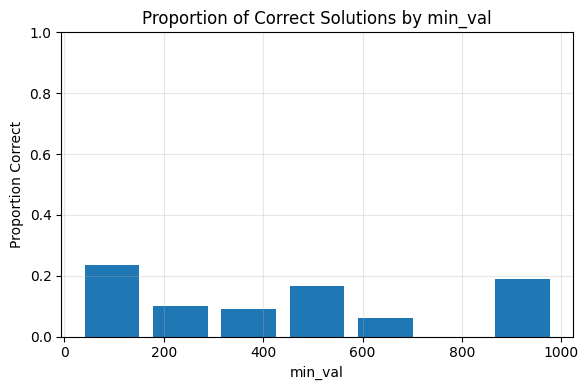

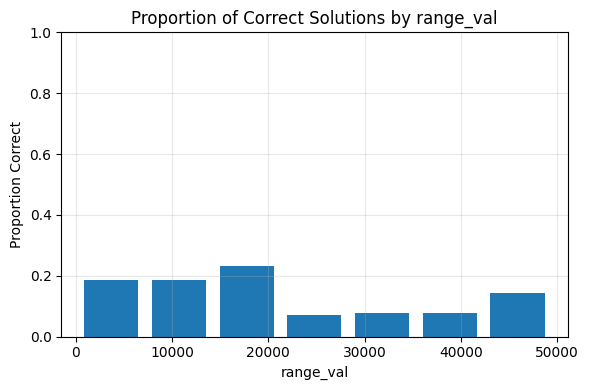

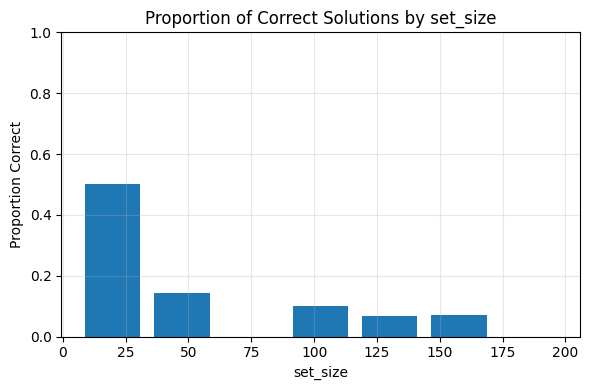

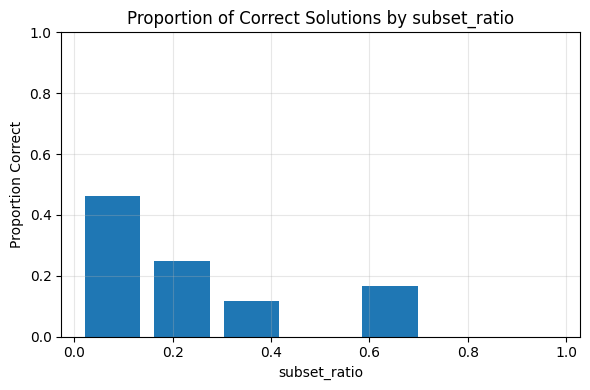

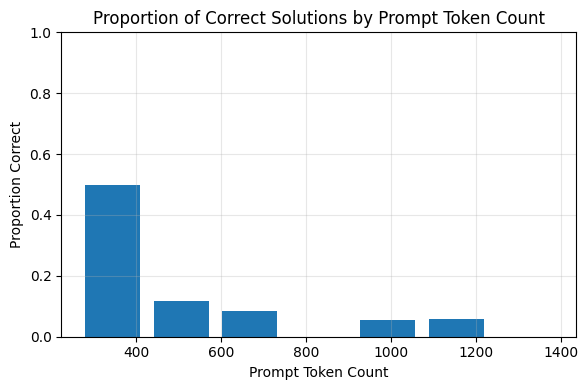

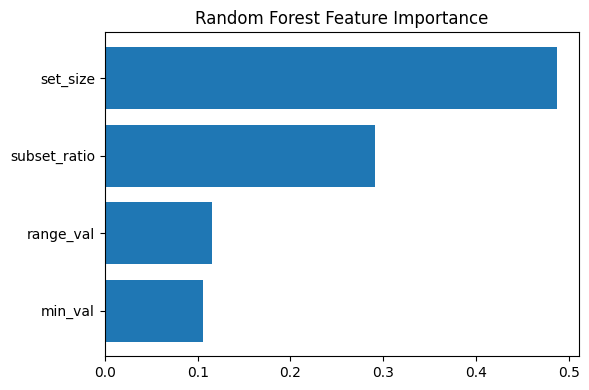

Accuracy: 0.95
F1 Score: 0.8
LLM Solve Time (Average): 14.011781308650972
LLM Solve Time (STD): 1.7763568394002505e-15
Z3 Solve Time (Average): 0.055424816608428955
Z3 Solve Time (STD): 0.0391502870681489


In [ ]:
results = load_results(os.path.join(path, 'SSP.pkl'))
report_results(results)

### Tools

## Minimum Vertex Cover Problem

### Baseline

In [ ]:
import re
import time
from langchain_core.messages import SystemMessage, HumanMessage

def format_graph_problem_for_llm(generated_graph):
    prompt = (f"Total vertices: {len(generated_graph)}\n"
              "Generated Graph:\n"
    )
    for vertex, neighbors in sorted(generated_graph.items()):
        prompt += f"   {vertex}: {sorted(neighbors)}\n"
    return prompt

def create_vc_prompt(formatted_problem_str):
    system_content = (
        "You are an expert graph algorithm solver specializing in Minimum "
        "Vertex Cover Problems. You will receive an undirected graph where "
        "each line contains a vertex and its adjacent vertices. Your task "
        "is to find the smallest possible subset of vertices such "
        "that every edge in the graph has at least one endpoint in this subset.\n\n"

        "CRITICAL REQUIREMENTS:\n"
        "- The solution must be minimal (no smaller valid vertex cover exists)\n"
        "- Every edge must be covered (have at least one endpoint in the selected subset)\n"
        "- Show your reasoning process step by step\n"
        "- Return only the final vertex set as a comma-separated list in brackets without any additional texts., e.g., [v1, v3, v5]"
    )

    human_content = (
        f"Please solve the following Minimum Vertex Cover Problem:\n\n{formatted_problem_str}\n\n"

        "Follow these steps to find a solution:\n"
        "1.  **Graph Analysis**\n"
        "    * Identify all vertices and edges from the input.\n"
        "    * Note any isolated vertices (they don't need to be in the cover).\n"
        "    * Identify high-degree vertices (good candidates for the cover).\n"
        "    * Start by identifying potential vertices, beginning with high-degree vertices.\n"
        "2.  **Initial Solution**\n"
        "    * Start with an initial subset of the vertices.\n"
        "    * Ensure all edges are covered by your initial selection.\n"
        "3.  **Iterate and Refine the Subset**\n"
        "    * If all the edges are covered, try to minimize the size of the subset by adjusting it.\n"
        "    * If not, you need to adjust the subset to cover them all.\n"
        "    * Adjust the subset by adding or removing vertices.\n"
        "    * Continue until no further reduction is possible and all the edges are covered.\n"
        "4.  **Conclusion**\n"
        "    * Provide the final set of vertices in the required format without any additional texts.\n"
    )

    sys_msg = SystemMessage(content=system_content)
    human_msg = HumanMessage(content=human_content)

    return sys_msg, human_msg

In [ ]:
args = TestProblemArgs(chat_model, generate_vc_problem,
                      lambda ans,g,sol: verify_vc_solution(ans,g,len(sol)),
                      lambda g,_: solve_vertex_cover_with_z3(g),
                      extract_subset_from_output, format_graph_problem_for_llm,
                      create_vc_prompt)

In [ ]:
args.generator_args = {'num_vertices': 8, 'vc_ratio': 0.4, 'edge_density':0.5}
result = test_one_problem(args)
print_one_result(result)

---------------------------------------------------------------------------
Parameters:
---------------------------------------------------------------------------
Generator Parameters:
{'num_vertices': 8, 'vc_ratio': 0.4, 'edge_density': 0.5}
---------------------------------------------------------------------------
Generated:
({0: [3], 1: [2, 3], 2: [1, 4, 7], 3: [6, 0, 1, 4, 5], 4: [6, 2, 3], 5: [3], 6: [4, 3], 7: [2]}, [4, 3, 2])
---------------------------------------------------------------------------
Formatted Problem:
Total vertices: 8
Generated Graph:
   0: [3]
   1: [2, 3]
   2: [1, 4, 7]
   3: [0, 1, 4, 5, 6]
   4: [2, 3, 6]
   5: [3]
   6: [3, 4]
   7: [2]

---------------------------------------------------------------------------
System Message:
content='You are an expert graph algorithm solver specializing in Minimum Vertex Cover Problems. You will receive an undirected graph where each line contains a vertex and its adjacent vertices. Your task is to find the smallest

In [ ]:
args.generator_args = {'num_vertices': 8, 'vc_ratio': 0.999999, 'edge_density':1}
print_one_result(test_one_problem(args))

---------------------------------------------------------------------------
Generated:
({0: [4, 1, 2, 3, 5, 6, 7], 1: [4, 0, 2, 3, 5, 6, 7], 2: [4, 0, 1, 3, 5, 6, 7], 3: [4, 0, 1, 2, 5, 6, 7], 4: [6, 1, 7, 2, 5, 3, 0], 5: [4, 0, 1, 2, 3, 6, 7], 6: [4, 0, 1, 2, 3, 5, 7], 7: [4, 0, 1, 2, 3, 5, 6]}, [6, 1, 7, 2, 5, 3, 0])
---------------------------------------------------------------------------
Formatted Problem:
Total vertices: 8
Generated Graph:
   0: [1, 2, 3, 4, 5, 6, 7]
   1: [0, 2, 3, 4, 5, 6, 7]
   2: [0, 1, 3, 4, 5, 6, 7]
   3: [0, 1, 2, 4, 5, 6, 7]
   4: [0, 1, 2, 3, 5, 6, 7]
   5: [0, 1, 2, 3, 4, 6, 7]
   6: [0, 1, 2, 3, 4, 5, 7]
   7: [0, 1, 2, 3, 4, 5, 6]

---------------------------------------------------------------------------
System Message:
content='You are an expert graph algorithm solver specializing in Minimum Vertex Cover Problems. You will receive an undirected graph where each line contains a vertex and its adjacent vertices. Your task is to find the smallest pos

In [ ]:
args.generator_args = {'num_vertices': 500, 'vc_ratio': 0.5, 'edge_density':0.1}
print_one_result(test_one_problem(args))

---------------------------------------------------------------------------
Generated:
({0: [213, 259, 54, 75, 122, 137, 139, 178, 228, 251, 252, 265, 301, 302, 308, 309, 326, 342, 385, 413, 430, 445, 461], 1: [328, 4, 10, 20, 40, 68, 75, 99, 126, 129, 133, 140, 163, 172, 176, 186, 190, 192, 201, 221, 225, 227, 240, 259, 263, 295, 305, 338, 352, 354, 369, 392, 413, 426, 434, 442, 450, 454, 456, 461, 468, 474, 483, 498], 2: [5, 36, 59, 75, 102, 107, 116, 125, 130, 134, 161, 178, 187, 188, 226, 271, 273, 283, 312, 330, 365, 377, 388, 393, 412, 413, 432, 441, 453], 3: [316, 11, 13, 26, 27, 43, 46, 52, 81, 100, 105, 120, 126, 127, 136, 141, 143, 148, 158, 181, 187, 194, 197, 201, 207, 214, 223, 230, 295, 297, 298, 313, 354, 377, 404, 417, 422, 429, 433, 447, 456, 483], 4: [162, 260, 1, 13, 36, 53, 54, 59, 76, 83, 102, 114, 115, 140, 155, 192, 198, 213, 261, 264, 265, 302, 313, 392, 405, 412, 421, 423, 472, 476], 5: [303, 2, 7, 15, 17, 18, 24, 27, 39, 40, 45, 77, 79, 82, 107, 108, 114, 115,

In [ ]:
n_problems = 100
args.generator_args = {'num_vertices': randint(5,151), 'vc_ratio': uniform(0,1), 'edge_density': uniform(0,1)}

results = test_many_problems(args, n_problems, random_state=42)
add_z3_result(results, args)

save_results(results, os.path.join(path, 'VC.pkl'))

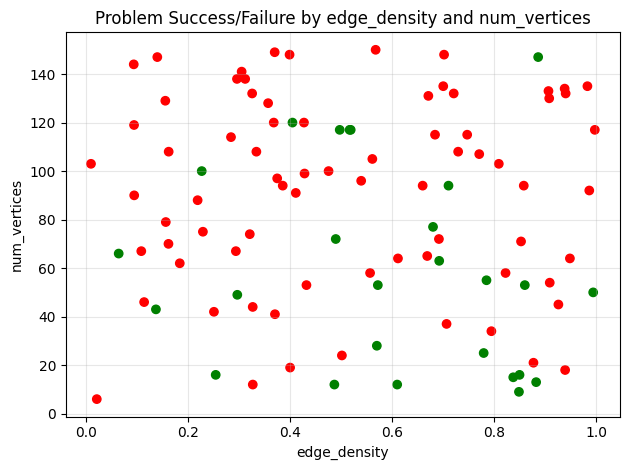

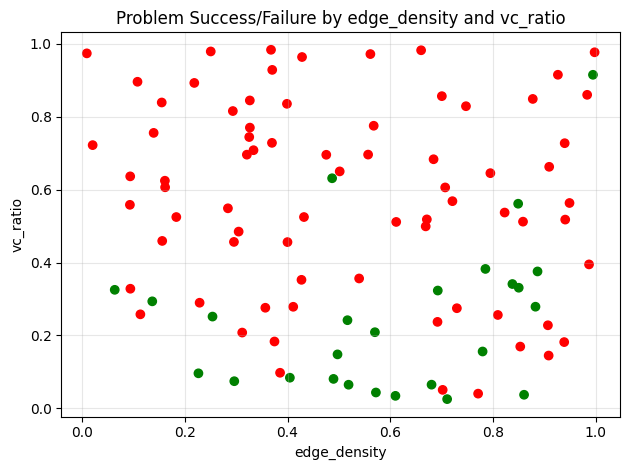

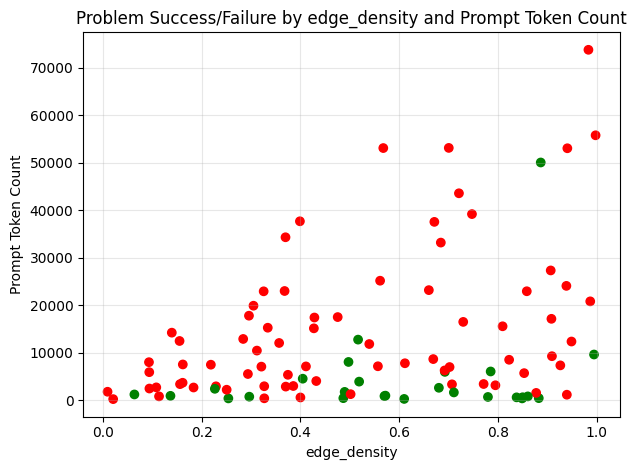

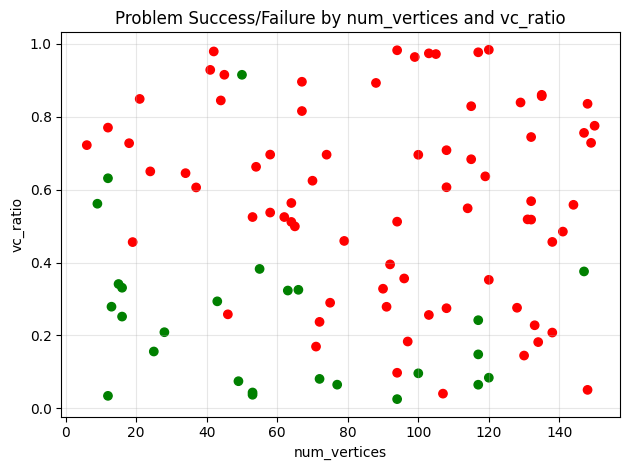

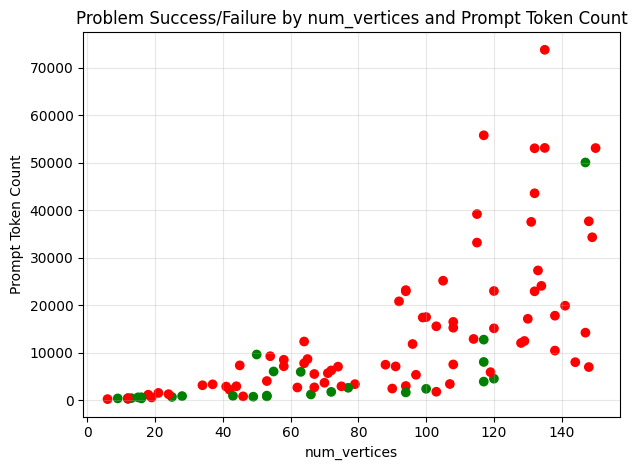

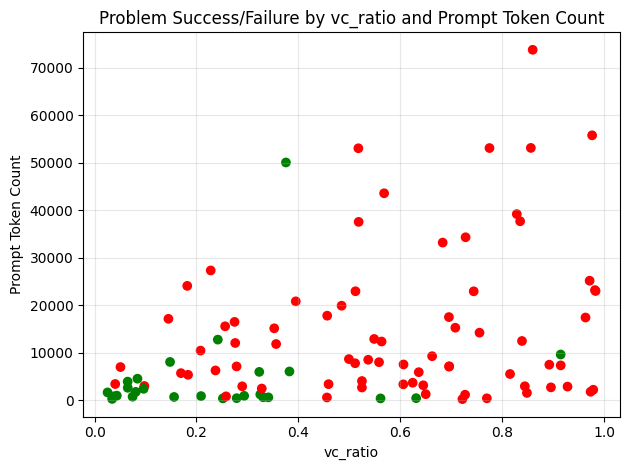

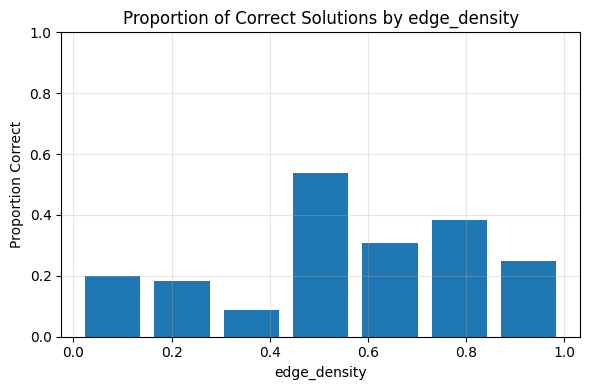

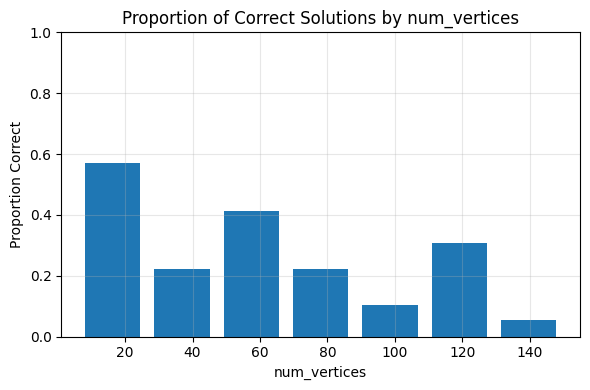

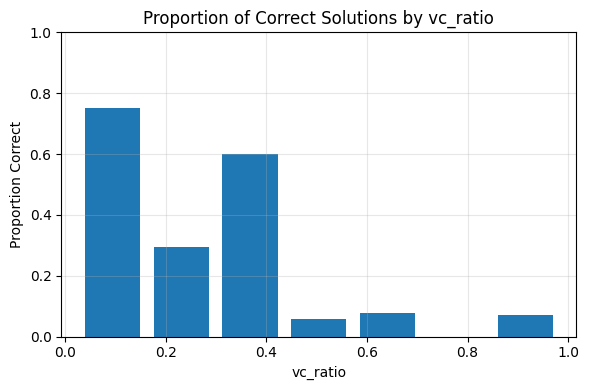

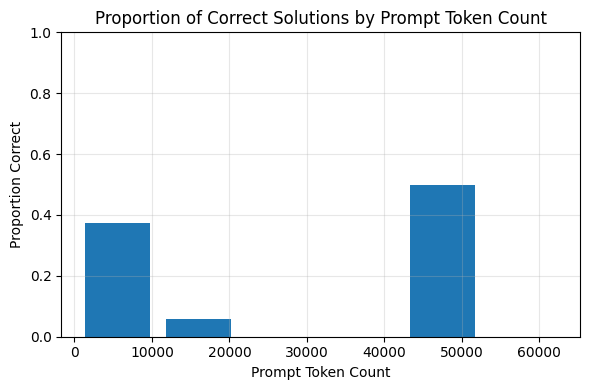

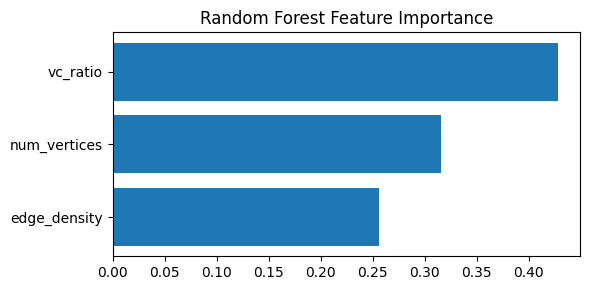

Accuracy: 0.95
F1 Score: 0.8888888888888888
LLM Solve Time (Average): 22.78093029499053
LLM Solve Time (STD): 1.0658141036401503e-14
Z3 Solve Time (Average): 5.929578802585602
Z3 Solve Time (STD): 54.387339107467646


In [ ]:
results = load_results(os.path.join(path, 'VC.pkl'))
report_results(results)

## Maximum Clique Problem

### Baseline

In [ ]:
import re
import time
from langchain_core.messages import SystemMessage, HumanMessage

def create_clique_prompt(formatted_problem_str):
    system_content = (
        "You are an expert in graph theory specializing in Maximum "
        "Clique Problems. You will receive an undirected graph where "
        "each line contains a vertex and its adjacent vertices. Your task "
        "is to find the maximum clique in the graph.\n\n"

        "CRITICAL REQUIREMENTS:\n"
        "- The solution must be maximum (no greater clique exists)\n"
        "- Show your reasoning process step by step\n"
        "- Return only the final set of vertices as a comma-separated list in brackets without any additional texts., e.g., [v1, v3, v5]"
    )

    human_content = (
        f"Please solve the following Maximum Clique Problem:\n\n{formatted_problem_str}\n\n"

        "Follow these steps to find a solution:\n"
        "1.  **Graph Analysis**\n"
        "    * Identify all vertices and edges from the input.\n"
        "    * Identify high-degree vertices (good candidates for the cover).\n"
        "    * Start by identifying potential cliques, beginning with high-degree vertices.\n"
        "2.  **Initial Solution**\n"
        "    * Start with an initial subset of the vertices.\n"
        "    * Ensure the subset produces a clique.\n"
        "3.  **Iterate and Refine**\n"
        "    * If the subset produces a clique, try to maxmize the size of the subset by adjusting it.\n"
        "    * If not, you need to add or remove vertices the subset to reach a clique.\n"
        "    * Adjust the subset by adding or removing vertices.\n"
        "    * Repeat until no further refinement is possible and the greatest clique is found.\n"
        "4.  **Conclusion**\n"
        "    * Provide the final set of vertices in the required format without any additional texts.\n"
    )

    sys_msg = SystemMessage(content=system_content)
    human_msg = HumanMessage(content=human_content)

    return sys_msg, human_msg

In [ ]:
args = TestProblemArgs(chat_model, generate_clique_problem,
                      lambda ans,g,sol: verify_clique_solution(ans,g,len(sol)),
                      lambda g,_: solve_max_clique_with_z3(g),
                      extract_subset_from_output, format_graph_problem_for_llm,
                      create_clique_prompt)

In [ ]:
args.generator_args = {'num_vertices': 10, 'clique_ratio': 0.4, 'edge_density':0.5}
result = test_one_problem(args)
print_one_result(result)

---------------------------------------------------------------------------
Generated:
({0: [3, 8, 2, 1], 1: [7, 9, 2, 4, 3, 0], 2: [7, 9, 1, 8, 0], 3: [8, 5, 0, 9, 1], 4: [6, 1], 5: [6, 3, 9], 6: [4, 5, 7], 7: [9, 2, 1, 6], 8: [3, 0, 9, 2], 9: [7, 2, 1, 3, 8, 5]}, [7, 9, 2, 1])
---------------------------------------------------------------------------
Formatted Problem:
Total vertices: 10
Generated Graph:
   0: [1, 2, 3, 8]
   1: [0, 2, 3, 4, 7, 9]
   2: [0, 1, 7, 8, 9]
   3: [0, 1, 5, 8, 9]
   4: [1, 6]
   5: [3, 6, 9]
   6: [4, 5, 7]
   7: [1, 2, 6, 9]
   8: [0, 2, 3, 9]
   9: [1, 2, 3, 5, 7, 8]

---------------------------------------------------------------------------
System Message:
content='You are an expert in graph theory specializing in Maximum Clique Problems. You will receive an undirected graph where each line contains a vertex and its adjacent vertices. Your task is to find the maximum clique in the graph.\n\nCRITICAL REQUIREMENTS:\n- The solution must be maximum (no gr

In [ ]:
args.generator_args = {'num_vertices': 20, 'clique_ratio': 0.25, 'edge_density':0.5}
print_one_result(test_one_problem(args))

---------------------------------------------------------------------------
Generated:
({0: [9, 5, 6, 1, 18, 2, 15], 1: [5, 17, 11, 12, 0, 10, 8, 16, 2, 14], 2: [8, 16, 14, 15, 12, 3, 1, 0], 3: [11, 10, 16, 2, 15], 4: [6, 12, 7, 8, 16], 5: [9, 6, 1, 0, 7, 8, 16], 6: [9, 19, 5, 11, 4, 13, 0, 8, 16, 14], 7: [5, 11, 12, 4, 10, 16], 8: [16, 2, 14, 15, 5, 17, 6, 4, 1, 18], 9: [19, 5, 6, 0, 18], 10: [11, 12, 3, 1, 13, 7, 18, 16, 15], 11: [17, 6, 3, 1, 10, 7, 18, 16, 15], 12: [17, 4, 1, 10, 7, 18, 2, 15], 13: [19, 6, 10, 16], 14: [8, 16, 2, 15, 19, 6, 1, 18], 15: [8, 16, 2, 14, 19, 17, 11, 12, 3, 0, 10], 16: [8, 2, 14, 15, 5, 6, 11, 4, 3, 1, 13, 10, 7, 18], 17: [19, 11, 12, 1, 18, 8, 15], 18: [9, 17, 11, 12, 0, 10, 8, 16, 14], 19: [9, 17, 6, 13, 14, 15]}, [8, 16, 2, 14, 15])
---------------------------------------------------------------------------
Formatted Problem:
Total vertices: 20
Generated Graph:
   0: [1, 2, 5, 6, 9, 15, 18]
   1: [0, 2, 5, 8, 10, 11, 12, 14, 16, 17]
   2: [0, 1, 3, 8

In [ ]:
args.generator_args = {'num_vertices': 200, 'clique_ratio': 0.9, 'edge_density':0.5}
print_one_result(test_one_problem(args))

---------------------------------------------------------------------------
Generated:
({0: [82, 104, 60, 144, 98, 62, 131, 95, 15, 52, 159, 1, 89, 81, 99, 189, 96, 119, 166, 193, 33, 94, 91, 57, 41, 150, 112, 20, 59, 161, 66, 196, 109, 79, 190, 71, 102, 10, 170, 182, 149, 84, 74, 42, 5, 155, 16, 138, 13, 75, 163, 179, 8, 19, 35, 39, 168, 87, 28, 9, 97, 184, 50, 128, 194, 27, 172, 107, 73, 110, 32, 121, 134, 4, 72, 127, 56, 105, 69, 108, 145, 45, 68, 106, 3, 130, 63, 146, 185, 103, 133, 37, 154, 151, 135, 126, 124, 118, 197, 46, 21, 38, 157, 31, 183, 181, 140, 93, 137, 132, 76, 100, 40, 23, 49, 88, 152, 142, 125, 187, 90, 29, 11, 136, 22, 175, 17, 148, 191, 173, 61, 117, 188, 143, 34, 26, 147, 158, 67, 139, 169, 180, 186, 156, 92, 25, 115, 2, 51, 70, 54, 6, 122, 77, 141, 111, 171, 162, 195, 48, 113, 176, 55, 86, 53, 85, 7, 164, 123, 165, 167, 30, 177, 64, 198, 36, 65, 160, 192, 174, 47, 12, 199, 129, 43, 18], 1: [82, 104, 60, 144, 98, 62, 131, 95, 15, 52, 159, 89, 81, 99, 189, 96, 119,

In [ ]:
n_problems = 100
args.generator_args = {'num_vertices': randint(5,151), 'clique_ratio': uniform(0,1), 'edge_density': uniform(0,1)}

results = test_many_problems(args, n_problems, random_state=42)
add_z3_result(results, args)

save_results(results, os.path.join(path, 'CLIQUE.pkl'))

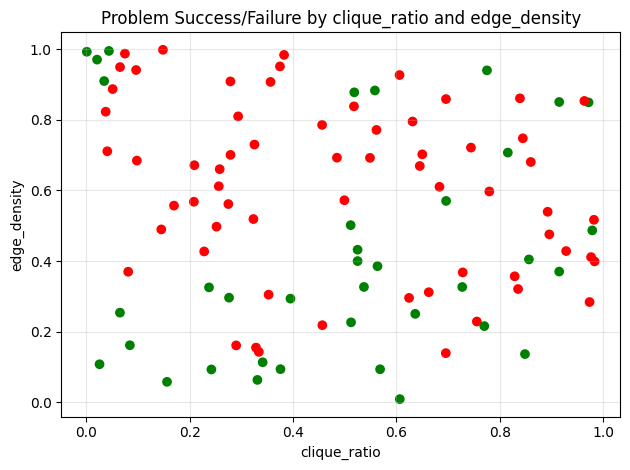

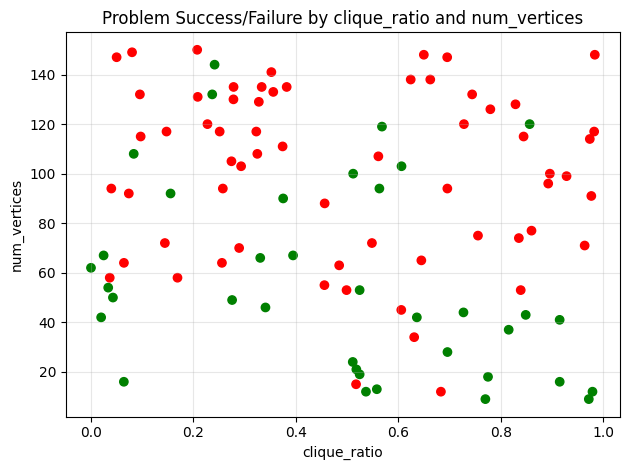

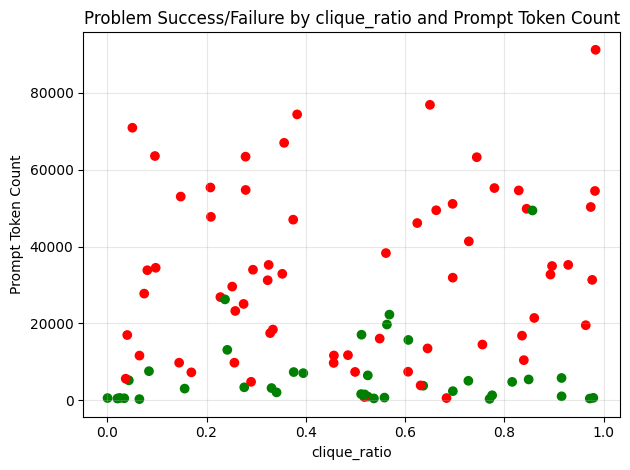

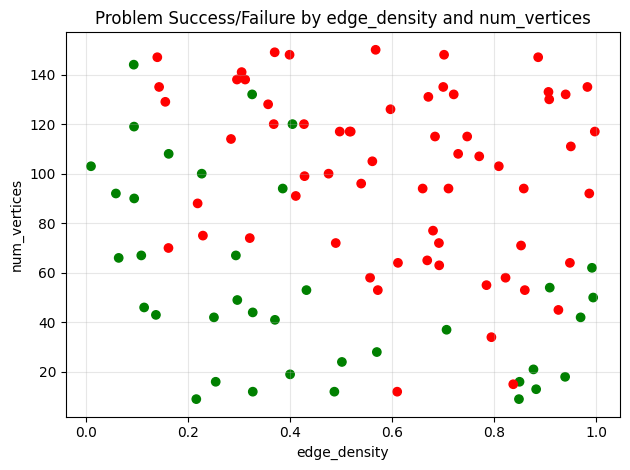

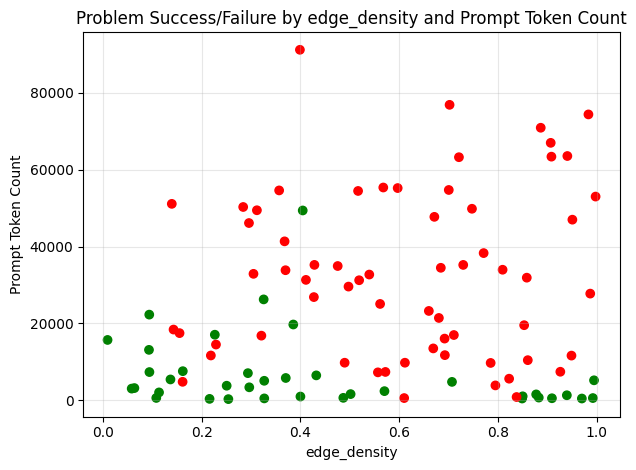

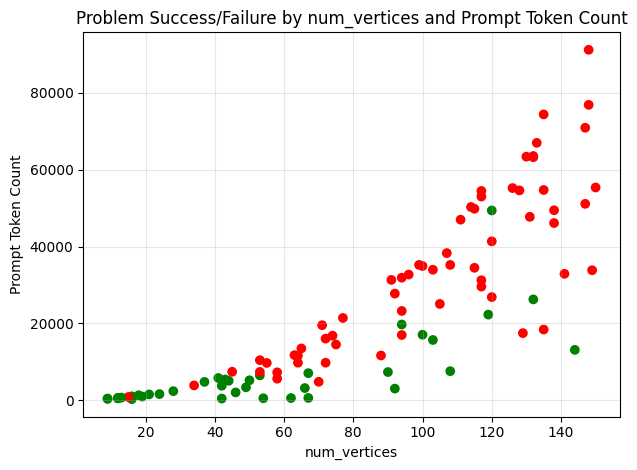

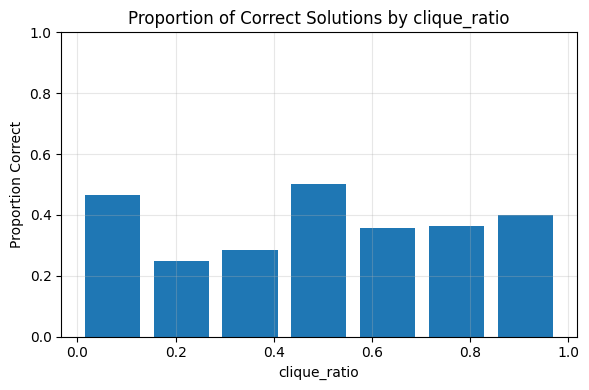

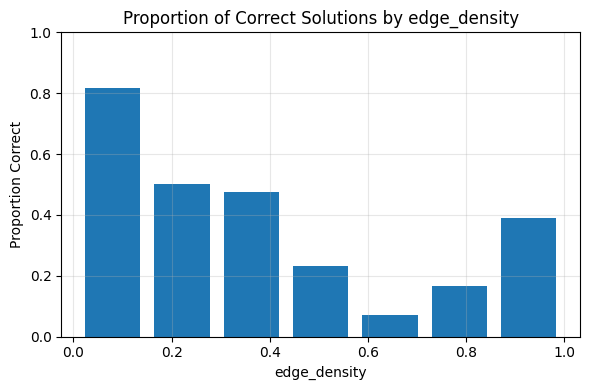

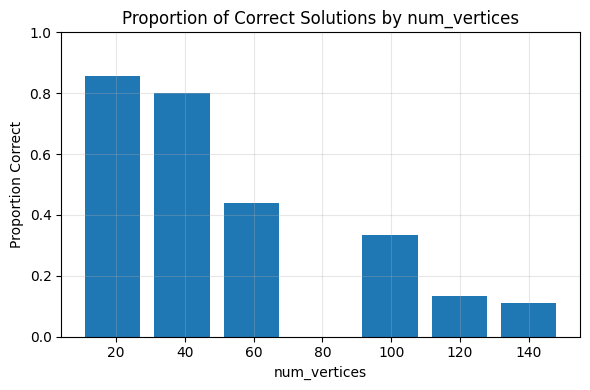

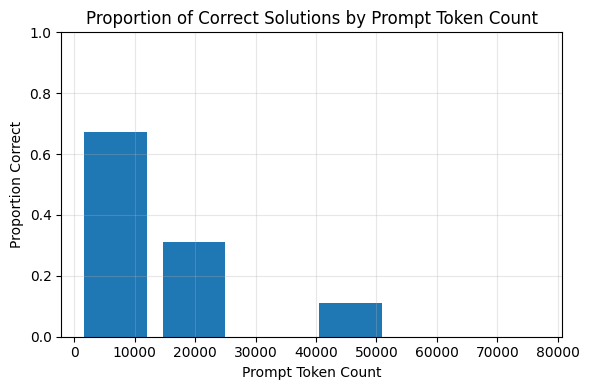

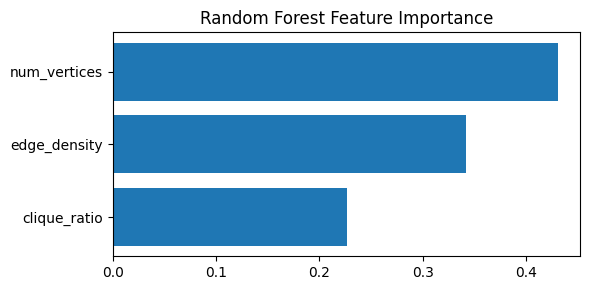

Accuracy: 0.75
F1 Score: 0.7058823529411765
LLM Solve Time (Average): 28.519452185630797
LLM Solve Time (STD): 0.0
Z3 Solve Time (Average): 0.39432176351547243
Z3 Solve Time (STD): 1.4191444735508736


In [ ]:
results = load_results(os.path.join(path, 'CLIQUE.pkl'))
report_results(results)

## Hamiltonian Path Problem

### Baseline

In [ ]:
import re
import time
from langchain_core.messages import SystemMessage, HumanMessage

def create_ham_path_prompt(formatted_problem_str):
    system_content = (
        "You are an expert in graph theory specializing in Hamiltonian "
        "Path Problem. You will receive an undirected graph where "
        "each line contains a vertex and its adjacent vertices. Your task "
        "is to determine if there exists a path that visits every vertex exactly once."
        "If such a path exists, you must provide the sequence of vertices. If not, "
        "you must state that.\n\n"

        "CRITICAL REQUIREMENTS:\n"
        "- The path must visit every vertex exactly once\n"
        "- Consecutive vertices in the path must be connected by an edge\n"
        "- Show your reasoning process step by step\n"
        "- If a path exists, return only the final sequence of vertices as a comma-separated list in brackets without any additional texts., e.g., [v1, v3, v5]"
        "- If no path exists, return 'NO HAMILTONIAN PATH EXISTS'\n"
    )

    human_content = (
        f"Please solve the following Hamiltonian Path Problem:\n\n{formatted_problem_str}\n\n"

        "Follow these steps to find a solution:\n"
        "1.  **Graph Analysis**\n"
        "    * Identify all vertices and edges from the input.\n"
        "    * Identify high-degree and low-degree vertices.\n"
        "    * Check necessary conditions:\n"
        "        Graph must be connected.\n"
        "        At most 2 vertices can have odd degree.\n"
        "        Vertices with degree 1 can only be endpoints.\n"
        "2.  **Initial Solution**\n"
        "    * Start with an initial sequence of the vertices.\n"
        "    * If exactly 2 vertices have odd degree, start from one of them.\n"
        "    * If all vertices have even degree, start from any vertex.\n"
        "    * Consider vertices with degree 1 as mandatory endpoints.\n"
        "    * Ensure the path is valid that means there is an edge between any two consequent vertices.\n"
        "3.  **Iterate and Refine**\n"
        "    * If a path is found:\n\n"
        "        Verify it contains all vertices exactly once.\n"
        "        Verify each consecutive pair is connected by an edge.\n"
        "        Present the path as [v1, v2, v3, ...].\n"
        "    * If no path exists:\n\n"
        "        Explain why (disconnected graph, degree constraints, etc.).\n"
        "        Return 'NO HAMILTONIAN PATH EXISTS'.\n"
        "4.  **Conclusion**\n"
        "    * Provide the final cycle in the required format without any additional texts or state that no hamiltonian path exists.\n"
    )

    sys_msg = SystemMessage(content=system_content)
    human_msg = HumanMessage(content=human_content)

    return sys_msg, human_msg

In [ ]:
args = TestProblemArgs(chat_model, generate_hamiltonian_path_graph,
                      lambda ans,g,_: verify_hamiltonian_path(ans,g),
                      lambda g,_: solve_hamiltonian_path_with_z3(g),
                      extract_subset_from_output, format_graph_problem_for_llm,
                      create_ham_path_prompt)

In [ ]:
args.generator_args = {'num_vertices': 10, 'edge_density':0.2}
result = test_one_problem(args)
print_one_result(result)

---------------------------------------------------------------------------
Generated:
({0: [5, 9, 3, 8], 1: [4, 7], 2: [9, 3, 5], 3: [2, 8, 0], 4: [8, 1], 5: [6, 0, 2], 6: [5], 7: [1], 8: [3, 4, 0, 9], 9: [0, 2, 8]}, [6, 5, 0, 9, 2, 3, 8, 4, 1, 7])
---------------------------------------------------------------------------
Formatted Problem:
Total vertices: 10
Generated Graph:
   0: [3, 5, 8, 9]
   1: [4, 7]
   2: [3, 5, 9]
   3: [0, 2, 8]
   4: [1, 8]
   5: [0, 2, 6]
   6: [5]
   7: [1]
   8: [0, 3, 4, 9]
   9: [0, 2, 8]

---------------------------------------------------------------------------
System Message:
content="You are an expert in graph theory specializing in Hamiltonian Path Problem. You will receive an undirected graph where each line contains a vertex and its adjacent vertices. Your task is to determine if there exists a path that visits every vertex exactly once.If such a path exists, you must provide the sequence of vertices. If not, you must state that.\n\nCRITICAL R

In [ ]:
args.generator_args = {'num_vertices': 20, 'edge_density':0.2}
result = test_one_problem(args)
print_one_result(result)

---------------------------------------------------------------------------
Generated:
({0: [1, 10, 4, 6, 14, 17, 18], 1: [19, 0, 2, 3, 5, 7, 9, 16], 2: [13, 7, 1, 4], 3: [7, 18, 1, 4, 8, 9, 11, 13], 4: [16, 19, 0, 2, 3, 10, 13, 18], 5: [15, 12, 1, 18], 6: [10, 17, 0, 13, 19], 7: [2, 3, 1, 10, 12, 13], 8: [11, 3, 9, 10], 9: [14, 11, 1, 3, 8, 12, 13, 17, 18, 19], 10: [0, 6, 4, 7, 8, 12, 18], 11: [9, 8, 3, 13, 19], 12: [5, 16, 7, 9, 10], 13: [2, 3, 4, 6, 7, 9, 11], 14: [17, 9, 0, 16, 18], 15: [18, 5], 16: [12, 4, 1, 14], 17: [6, 14, 0, 9, 19], 18: [3, 15, 0, 4, 5, 9, 10, 14], 19: [4, 1, 6, 9, 11, 17]}, [13, 2, 7, 3, 18, 15, 5, 12, 16, 4, 19, 1, 0, 10, 6, 17, 14, 9, 11, 8])
---------------------------------------------------------------------------
Formatted Problem:
Total vertices: 20
Generated Graph:
   0: [1, 4, 6, 10, 14, 17, 18]
   1: [0, 2, 3, 5, 7, 9, 16, 19]
   2: [1, 4, 7, 13]
   3: [1, 4, 7, 8, 9, 11, 13, 18]
   4: [0, 2, 3, 10, 13, 16, 18, 19]
   5: [1, 12, 15, 18]
   6: [0, 10

In [ ]:
n_problems = 100
args.generator_args = {'num_vertices': randint(5,151), 'edge_density': uniform(0,1)}

results = test_many_problems(args, n_problems, random_state=42)
save_results(results, os.path.join(path, 'HAMPATH.pkl'))

In [ ]:
add_z3_result(results[:10], args)
save_results(results, os.path.join(path, 'HAMPATH.pkl'))

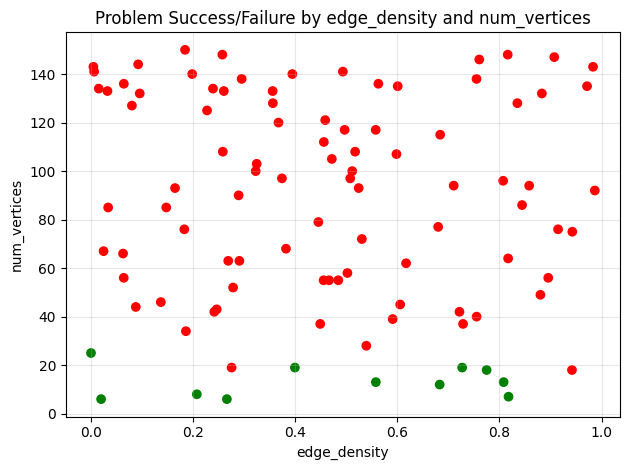

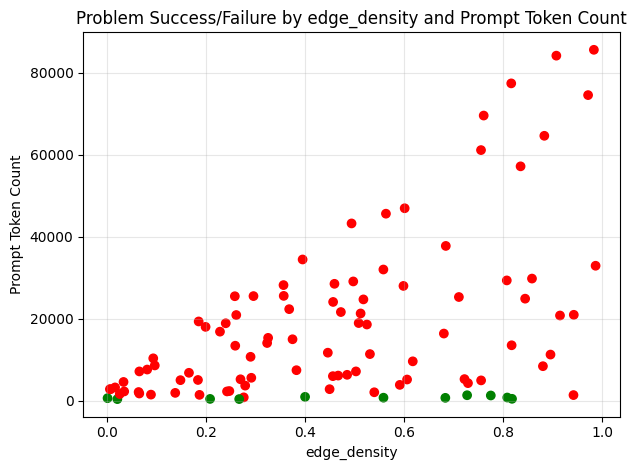

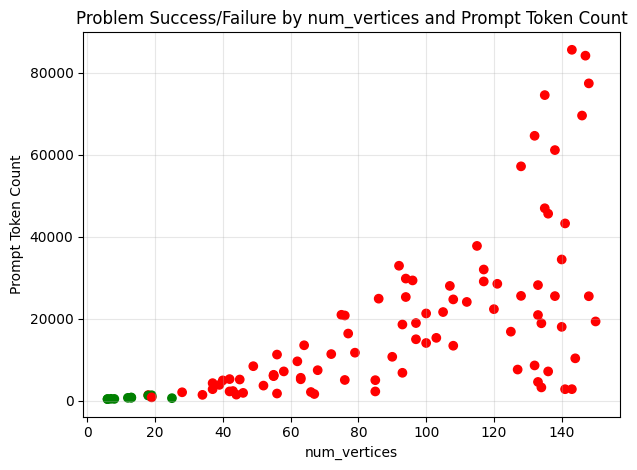

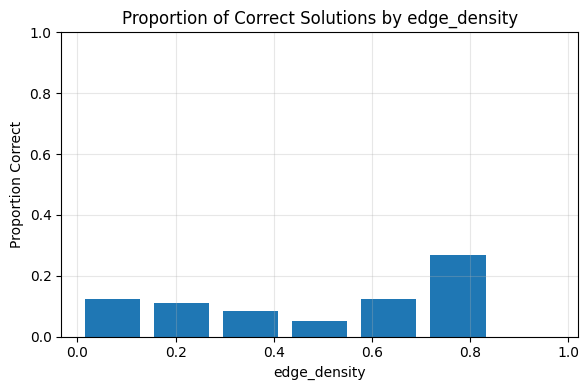

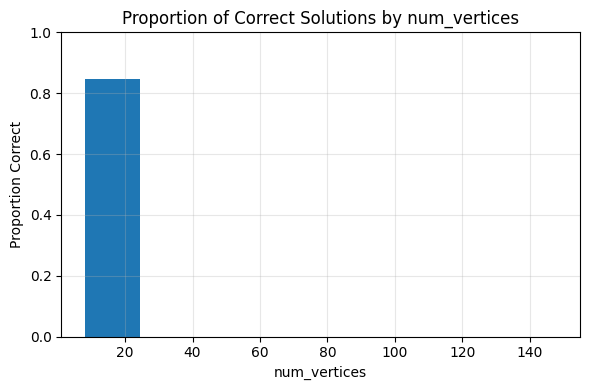

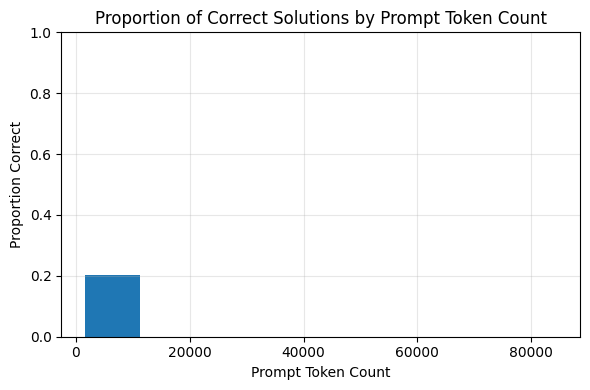

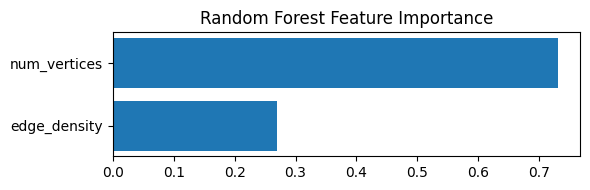

Accuracy: 1.0
F1 Score: 1.0
LLM Solve Time (Average): 22.306207509040824
LLM Solve Time (STD): 7.105427357601002e-15


In [ ]:
results = load_results(os.path.join(path, 'HAMPATH.pkl'))
report_results(results)

## Hamiltonian Cycle Problem

### Baseline

In [ ]:
import re
import time
from langchain_core.messages import SystemMessage, HumanMessage

def create_ham_cycle_prompt(formatted_problem_str):
    system_content = (
        "You are an expert in graph theory specializing in Hamiltonian "
        "Cycle Problem. You will receive an undirected graph where "
        "each line contains a vertex and its adjacent vertices. Your task "
        "is to determine if there exists a cycle that visits every vertex exactly once "
        "and then returns to the first vertex. If such a path exists, you must provide "
        "the sequence of vertices. If not, you must state that.\n\n"

        "CRITICAL REQUIREMENTS:\n"
        "- The cycle must visit every vertex exactly once except for the first vertex that is also the last vertex\n"
        "- Consecutive vertices in the cycle must be connected by an edge\n"
        "- Show your reasoning process step by step\n"
        "- The first vertex must also be the last vertex\n"
        "- If a Hamiltonian cycle exists, return only the final sequence of vertices as a comma-separated list in brackets without any additional texts., e.g., [v1, v3, v1]"
        "- If no Hamiltonian cycle exists, return 'NO HAMILTONIAN CYCLE EXISTS'.\n"
    )

    human_content = (
        f"Please solve the following Hamiltonian Cycle Problem:\n\n{formatted_problem_str}\n\n"

        "Follow these steps to find a solution:\n"
        "1.  **Graph Analysis**:\n"
        "    * Identify all vertices and edges from the input.\n"
        "    * Identify high-degree and low-degree vertices.\n"
        "2.  **Initial Solution**:\n"
        "    * Start with an initial cycle.\n"
        "    * Ensure the sequence is valid cycle that means there is an edge between any two consequent vertices.\n"
        "3.  **Iterate and Refine**:\n"
        "    * If a cycle is found:\n\n"
        "        Verify each vertex (except the first, which repeats at the end) appears exactly once.\n"
        "        Verify each consecutive pair is connected by an edge.\n"
        "        Present the cycle as [v1, v2, v3, ..., v1].\n"
        "    * If no cycle exists:\n\n"
        "        Explain why (disconnected graph, etc.).\n"
        "        Return 'NO HAMILTONIAN CYCLE EXISTS'.\n"
        "4.  **Conclusion**:\n"
        "    * Provide the final cycle in the required format without any additional texts or state that no hamiltonian cycle exists.\n"
    )

    sys_msg = SystemMessage(content=system_content)
    human_msg = HumanMessage(content=human_content)

    return sys_msg, human_msg

In [ ]:
args = TestProblemArgs(chat_model, generate_hamiltonian_cycle_graph,
                      lambda ans,g,_: verify_hamiltonian_cycle(ans[:-1],g),
                      lambda g,_: solve_hamiltonian_cycle_with_z3(g),
                      extract_subset_from_output, format_graph_problem_for_llm,
                      create_ham_cycle_prompt)

In [ ]:
args.generator_args = {'num_vertices': 10, 'edge_density':0.2}
print_one_result(test_one_problem(args))

---------------------------------------------------------------------------
Generated:
({0: [8, 2, 5, 6, 7], 1: [5, 8], 2: [0, 7, 6, 8], 3: [5, 9, 6], 4: [6, 9], 5: [3, 1, 0, 6, 7, 8], 6: [7, 4, 0, 2, 3, 5], 7: [2, 6, 0, 5], 8: [1, 0, 2, 5], 9: [4, 3]}, [3, 5, 1, 8, 0, 2, 7, 6, 4, 9])
---------------------------------------------------------------------------
Formatted Problem:
Total vertices: 10
Generated Graph:
   0: [2, 5, 6, 7, 8]
   1: [5, 8]
   2: [0, 6, 7, 8]
   3: [5, 6, 9]
   4: [6, 9]
   5: [0, 1, 3, 6, 7, 8]
   6: [0, 2, 3, 4, 5, 7]
   7: [0, 2, 5, 6]
   8: [0, 1, 2, 5]
   9: [3, 4]

---------------------------------------------------------------------------
System Message:
content="You are an expert in graph theory specializing in Hamiltonian Cycle Problem. You will receive an undirected graph where each line contains a vertex and its adjacent vertices. Your task is to determine if there exists a cycle that visits every vertex exactly once and then returns to the first vert

In [ ]:
args.generator_args = {'num_vertices': 20, 'edge_density':0.7}
print_one_result(test_one_problem(args))

---------------------------------------------------------------------------
Generated:
({0: [5, 3, 2, 4, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18], 1: [14, 17, 2, 3, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19], 2: [3, 14, 0, 1, 4, 5, 6, 7, 8, 12, 13, 16, 17, 18], 3: [0, 2, 1, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 19], 4: [11, 9, 0, 2, 5, 6, 7, 10, 12, 13, 14, 16, 17, 19], 5: [8, 0, 2, 3, 4, 6, 7, 11, 14, 15, 19], 6: [12, 13, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19], 7: [19, 10, 0, 1, 2, 4, 5, 6, 8, 13, 15, 16, 17], 8: [18, 5, 1, 2, 6, 7, 9, 12, 13, 14, 16, 17, 19], 9: [4, 18, 0, 1, 3, 6, 8, 10, 12, 14, 15, 16, 17, 19], 10: [7, 12, 0, 1, 3, 4, 6, 9, 11, 13, 14, 15, 17, 19], 11: [13, 4, 0, 1, 3, 5, 6, 10, 14, 15, 16], 12: [6, 10, 0, 1, 2, 3, 4, 8, 9, 13, 15, 16, 17, 18, 19], 13: [6, 11, 0, 1, 2, 3, 4, 7, 8, 10, 12, 14, 16, 17, 18, 19], 14: [2, 1, 0, 4, 5, 6, 8, 9, 10, 11, 13, 15, 17, 18], 15: [17, 16, 0, 1, 3, 5, 6, 7, 9, 10, 11, 12, 14, 18], 16: [15, 19, 0, 1, 2, 3, 4, 6, 7, 8, 9, 1

In [ ]:
n_problems = 100
args.generator_args = {'num_vertices': randint(5,151), 'edge_density': uniform(0,1)}

results = test_many_problems(args, n_problems, random_state=42)
save_results(results, os.path.join(path, 'HAMCYCLE.pkl'))

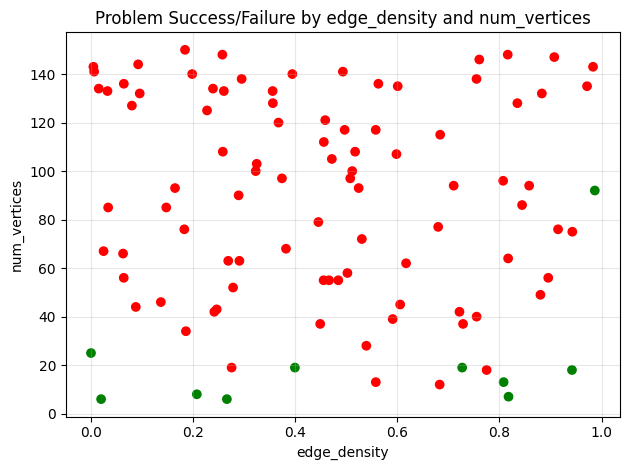

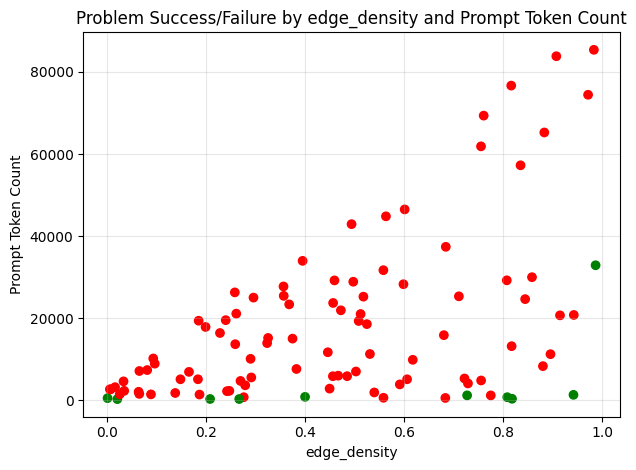

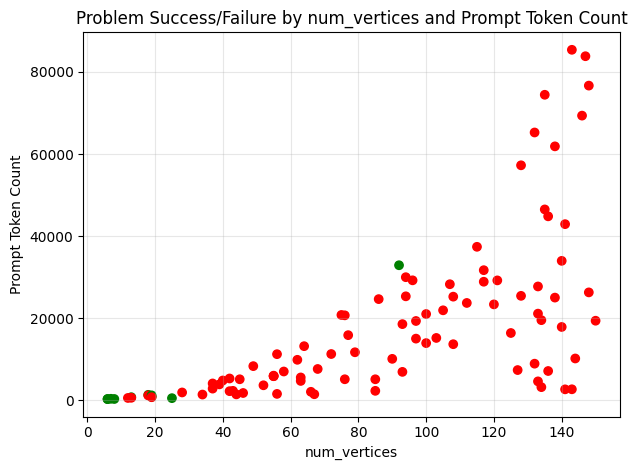

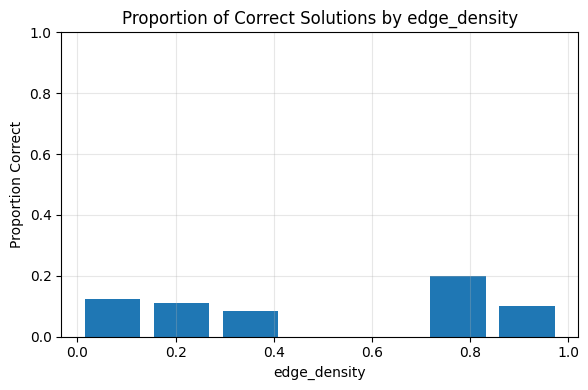

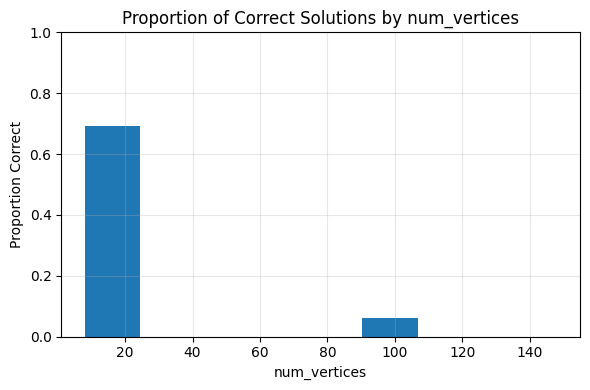

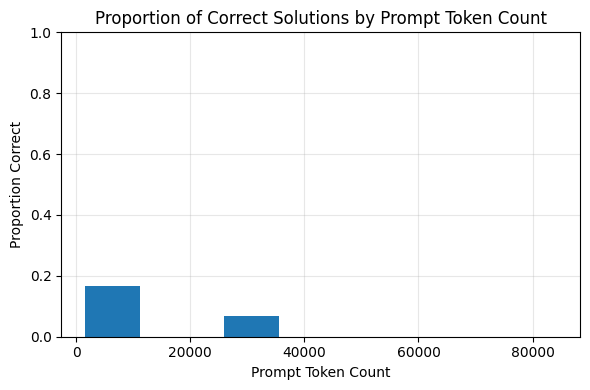

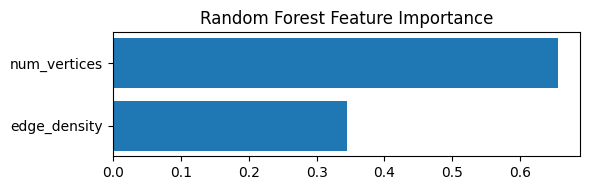

Accuracy: 0.95
F1 Score: 0.6666666666666666
LLM Solve Time (Average): 22.78467220783234
LLM Solve Time (STD): 3.552713678800501e-15


In [ ]:
results = load_results(os.path.join(path, 'HAMCYCLE.pkl'))
report_results(results)